#Imports

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
# Checking for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Loading Dataset

In [3]:
# Function to unpickle file
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')    # Each file  unpickled file returns a dictionary that contains batch label,labels,data ,filenames
    return data

batch_files = ['/content/data_batch_1', '/content/data_batch_2', '/content/data_batch_3', '/content/data_batch_4', '/content/data_batch_5']
data_batches = []
for file in batch_files:    # Function  to combine them
    data_batches.append(unpickle(file))



In [4]:
# Combining data
train_data = np.concatenate([batch[b'data'] for batch in data_batches], axis=0)
train_labels = np.concatenate([batch[b'labels'] for batch in data_batches], axis=0)
print(f'All the training data is of the shape :{train_data.shape}')
print(f"Its respective labels are of the shape :{train_labels.shape}")

All the training data is of the shape :(50000, 3072)
Its respective labels are of the shape :(50000,)


In [5]:
# Test Batch
test_batch = unpickle('/content/test_batch')
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])
print(f"All the test data is of the shape :{test_data.shape}")
print(f"Its respective labels are of the shape :{test_labels.shape}")

All the test data is of the shape :(10000, 3072)
Its respective labels are of the shape :(10000,)


#Preprocessing


In [6]:
# Preprocessing data
num_channels=3
img_size=32

def Pre_Process(samples):

  #Normalizing the datapoints
  raw_float = np.array(samples, dtype=float) / 255.0


  #Reshaping
  images = raw_float.reshape([-1, num_channels, img_size, img_size])
  images = images.transpose([0, 2, 3, 1])
  return images

In [7]:
# Preprocessing training data
train_data=Pre_Process(train_data)
train_data.shape

(50000, 32, 32, 3)

In [8]:
# Preprocessing test data
test_data=Pre_Process(test_data)
test_data.shape

(10000, 32, 32, 3)

#Vizualize

In [9]:
# Visualizing some samples
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_sample(X, y, index):
    plt.figure(figsize = (12,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

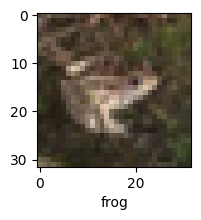

In [10]:
plot_sample(train_data,train_labels, 22)


In [11]:
train_labels

array([6, 9, 9, ..., 9, 1, 1])

#Model training

In [12]:
# Load pre-trained VGG16 model without the top dense layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the VGG16 layers
for layer in vgg_base.layers[:-3]:
    layer.trainable = False

In [13]:
# Defining Model Architecture

model = Sequential()

# Add the VGG16 base

model.add(vgg_base)

# Flatten the output of the VGG16 base

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Compile the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Training the model
model.fit(train_data,train_labels, epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 32s 16ms/step - loss: 1.1966 - accuracy: 0.5854
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9591 - accuracy: 0.6706
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.8766 - accuracy: 0.6977
Epoch 4/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.8123 - accuracy: 0.7201
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7644 - accuracy: 0.7361
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7207 - accuracy: 0.7494
Epoch 7/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.6773 - accuracy: 0.7660
Epoch 8/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.6444 - accuracy: 0.7754
Epoch 9/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.6037 - accuracy: 0.7885
Epoch 10/10
1563/1563 [==============================] - 20s 13m

On the training set the accuracy came to __79%__

#Test

313/313 [==============================] - 2s 7ms/step


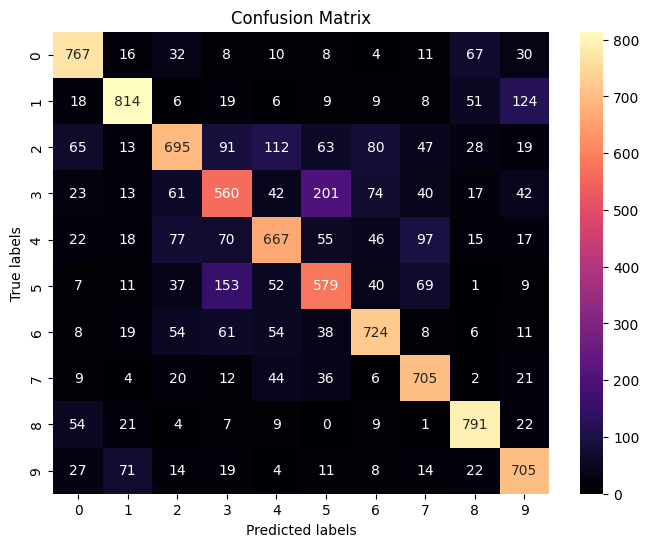

In [15]:
# Running model on test set
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)


# Generate confusion matrix
cm = confusion_matrix(predicted_classes, test_labels)

# Plotting the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='magma', fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



In [16]:
# Calculate accuracy

accuracy = accuracy_score(predicted_classes, test_labels)

print("Accuracy:", accuracy)

Accuracy: 0.7007


On the test set the accuracy came to __70%__

#Saving model

In [17]:
model.save("VGG16_M1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
